In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LassoLars, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error


Importing the datasets


In [6]:
train_df = pd.read_csv("datasetTask1/train.csv")
test_df = pd.read_csv("datasetTask1/test.csv")

print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)


train_df shape: (1460, 81)
test_df shape: (1459, 80)


Skew:  1.8828757597682129
Kurt:  6.536281860064529


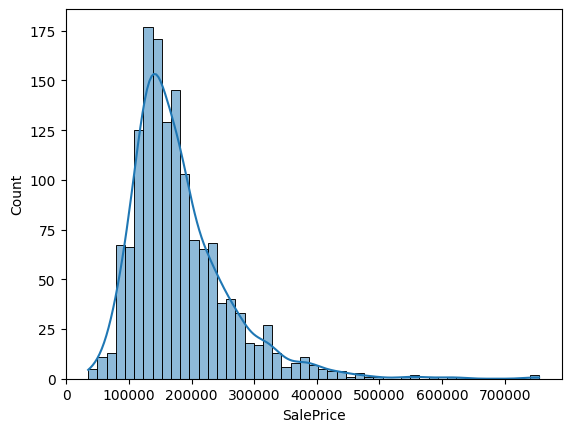

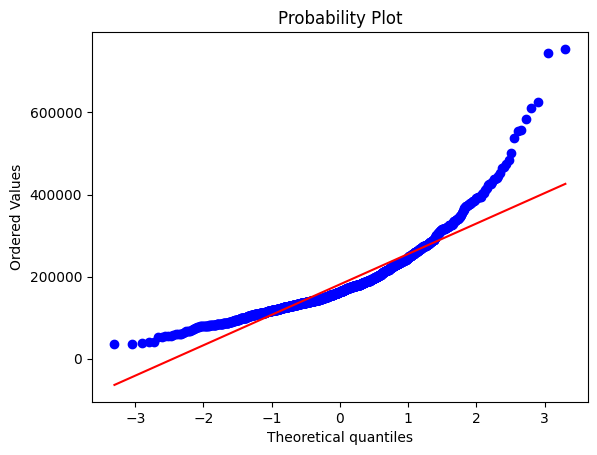

In [11]:
print("Skew: ", train_df['SalePrice'].skew())
print("Kurt: ", train_df['SalePrice'].kurt())
sns.histplot(train_df['SalePrice'], kde=True)
plt.figure()
stats.probplot(train_df['SalePrice'], plot=plt)


Skew:  0.12134661989685333
Kurt:  0.809519155707878


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.398259646654151, 12.024057394918403, 0.9953761551826701))

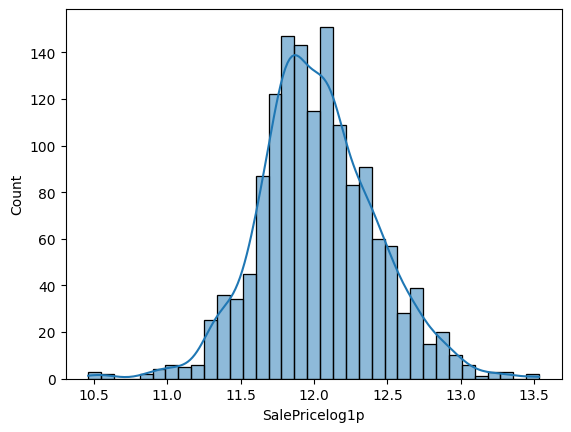

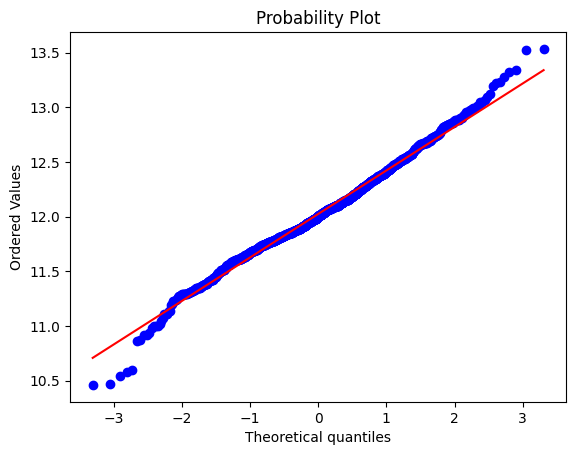

In [13]:
train_df['SalePricelog1p'] = np.log1p(train_df['SalePrice'])
print("Skew: ", train_df['SalePricelog1p'].skew())
print("Kurt: ", train_df['SalePricelog1p'].kurt())

# So applying scaling has improve skewness and Kurt which can be seen
# in below plot too
sns.histplot(train_df['SalePricelog1p'], kde=True)

# Plotting probability for SalePricelog1p
plt.figure()
stats.probplot(train_df['SalePricelog1p'], plot=plt)


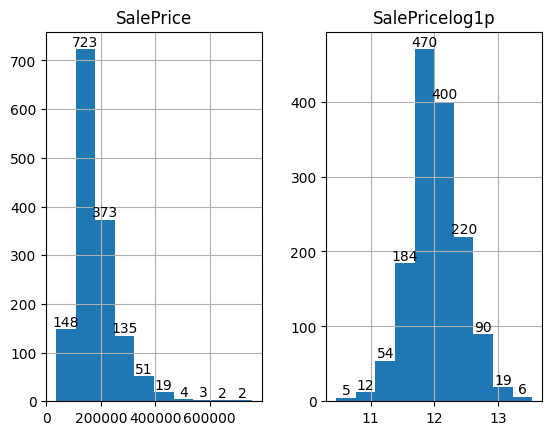

In [14]:
train_df[['SalePrice', 'SalePricelog1p']].hist()
for ax in plt.gcf().get_axes():

    for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height,
                int(height), ha='center', va='bottom')


In [15]:
# Analyzing data types of all the column
# print(f"{train_df.dtypes.unique()=}")
col_dtype = {}
count = 0
for item in train_df.dtypes.unique():
    key = "dt_"+str(item)
    col_dtype[key] = train_df.select_dtypes(include=[item]).columns.tolist()
    print("\n", "*"*100)
    print(f"Data Type: {item}, Num_col = {len(col_dtype[key])}")
    print(col_dtype[key])
    count += len(col_dtype[key])

assert len(
    train_df.columns) == count, "Total number of cols are not matching with data separated cols"



 ****************************************************************************************************
Data Type: int64, Num_col = 35
['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

 ****************************************************************************************************
Data Type: object, Num_col = 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Exte

Categorical Columns Correlation with SalePrice


In [16]:
categorical_train_df = train_df[col_dtype['dt_object']]


Missing Value management
Managing missing values in categorical columns

All cols having all NaN will be dropped

All cols missing more than 5% values will be dropped

All rows missing multiple values will be dropped


In [17]:
# Finding cols with all null values
train_df.columns[train_df.isnull().all()]


Index([], dtype='object')

In [18]:
# Calculating % of missing values
missing_values = train_df[col_dtype['dt_object']
                          ].isnull().sum()/len(train_df)*100
# Dropping column missing > 5% values
col_missing_5percent = missing_values[missing_values > 5]
categorical_train_df = categorical_train_df.drop(
    columns=col_missing_5percent.index)
col_dtype['dt_object'] = categorical_train_df.columns.tolist()

# Dropping Nan/Null value rows
categorical_train_df = categorical_train_df.dropna(
    thresh=categorical_train_df.shape[1])


In [19]:
# Printing unique values in each of the categorical col
for item in col_dtype['dt_object']:
    values = train_df[item].unique()
    print(f"{item}: {values}: {len(values)}\n")


MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']: 5

Street: ['Pave' 'Grvl']: 2

LotShape: ['Reg' 'IR1' 'IR2' 'IR3']: 4

LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']: 4

Utilities: ['AllPub' 'NoSeWa']: 2

LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']: 5

LandSlope: ['Gtl' 'Mod' 'Sev']: 3

Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']: 25

Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']: 9

Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']: 8

BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']: 5

HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']: 8

RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']: 6

RoofMatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'C

In [20]:
# Converting categorical values to numerical values
cat_num_train = [pd.factorize(categorical_train_df[col])[0]
                 for col in categorical_train_df.columns]
cat_num_train_df = pd.DataFrame(cat_num_train).T
cat_num_train_df.columns = categorical_train_df.columns
cat_num_train_df['SalePricelog1p'] = np.log1p(train_df['SalePrice'])
cat_num_train_df.shape


(1420, 34)

In [21]:
# Check if any column contains -ve number
(cat_num_train_df < 0).any()


MSZoning          False
Street            False
LotShape          False
LandContour       False
Utilities         False
LotConfig         False
LandSlope         False
Neighborhood      False
Condition1        False
Condition2        False
BldgType          False
HouseStyle        False
RoofStyle         False
RoofMatl          False
Exterior1st       False
Exterior2nd       False
ExterQual         False
ExterCond         False
Foundation        False
BsmtQual          False
BsmtCond          False
BsmtExposure      False
BsmtFinType1      False
BsmtFinType2      False
Heating           False
HeatingQC         False
CentralAir        False
Electrical        False
KitchenQual       False
Functional        False
PavedDrive        False
SaleType          False
SaleCondition     False
SalePricelog1p    False
dtype: bool

<Axes: >

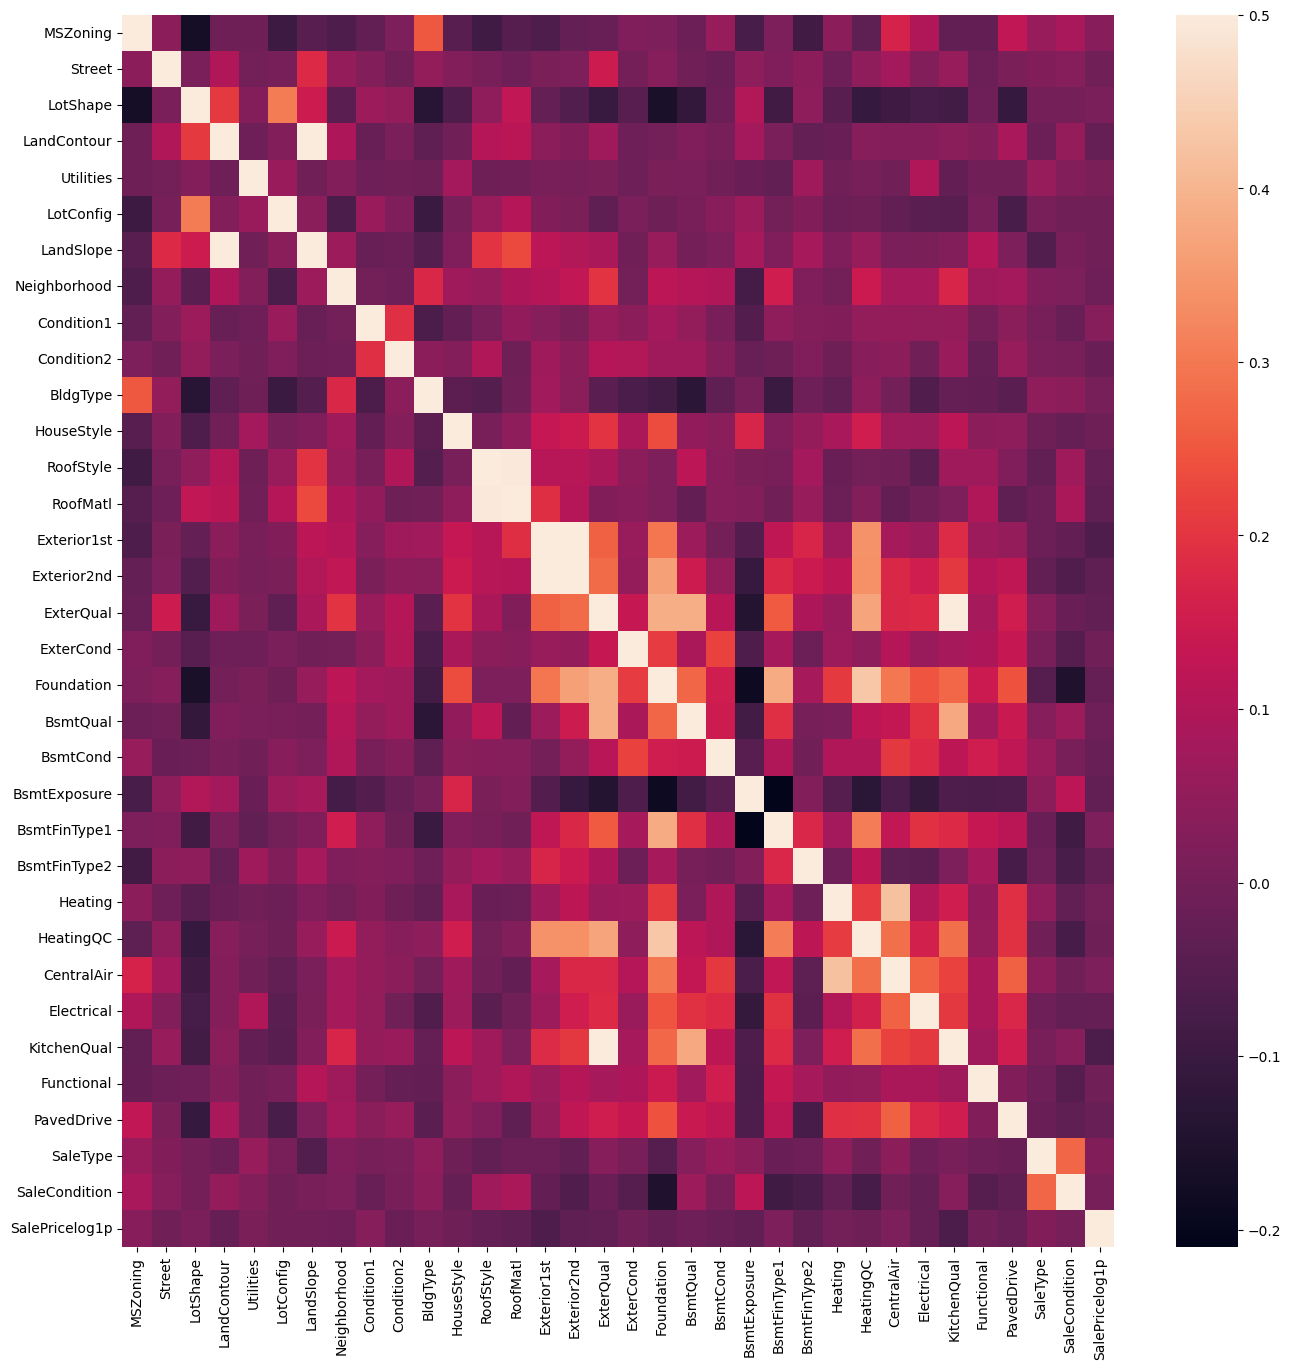

In [22]:
cat_num_train_df.columns
# We are using scaled values of SalePrice that is a better approach to calculate correlation
cat_corrmat = cat_num_train_df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(cat_corrmat, vmax=0.5)


In [23]:
cat_corrmat['SalePricelog1p'].sort_values(ascending=False)


SalePricelog1p    1.000000
MSZoning          0.032298
Condition1        0.030018
SaleType          0.022204
CentralAir        0.017541
BsmtFinType1      0.016700
Utilities         0.012357
LotShape          0.011206
BldgType          0.006131
SaleCondition     0.003718
Heating           0.000281
Functional       -0.002727
Street           -0.004955
ExterCond        -0.005901
LandSlope        -0.006325
LotConfig        -0.006603
Neighborhood     -0.008865
BsmtQual         -0.009352
HeatingQC        -0.010307
HouseStyle       -0.012400
Condition2       -0.017904
BsmtCond         -0.021004
PavedDrive       -0.021244
LandContour      -0.022681
Electrical       -0.022881
Foundation       -0.023162
RoofStyle        -0.024213
BsmtExposure     -0.030338
BsmtFinType2     -0.030443
ExterQual        -0.032031
RoofMatl         -0.033558
Exterior2nd      -0.035013
Exterior1st      -0.064006
KitchenQual      -0.065936
Name: SalePricelog1p, dtype: float64

Conclusion for Categorical colmns :
It is clear from the heat map that there is no significant correlation between SalePrice and other features. Sorting correlated values shows that highest level of correlation is below 0.05. That means we can easily ignore these columns and focus on rest of the columns.


Numerical data analysis and correlation with saleprice


In [24]:
# checkign for any negative value
inf_values = train_df.isin([float('inf'), float('-inf')])
inf_counts = inf_values.sum()
inf_counts[inf_counts > 0]


Series([], dtype: int64)

In [25]:
num_col = train_df.select_dtypes(include=['number']).columns
num_missing_val = train_df[num_col].isnull().sum()/len(train_df)
num_missing_val[num_missing_val > 0]
train_df[num_col]

# There are not many missing values in numerical columns


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePricelog1p
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,61,0,0,0,0,0,2,2008,208500,12.247699
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,0,5,2007,181500,12.109016
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,42,0,0,0,0,0,9,2008,223500,12.317171
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,35,272,0,0,0,0,2,2006,140000,11.849405
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,84,0,0,0,0,0,12,2008,250000,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,40,0,0,0,0,0,8,2007,175000,12.072547
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,0,0,0,0,0,0,2,2010,210000,12.254868
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,60,0,0,0,0,2500,5,2010,266500,12.493133
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,0,112,0,0,0,0,4,2010,142125,11.864469


Numerical cols correlation and heatmap


<Axes: >

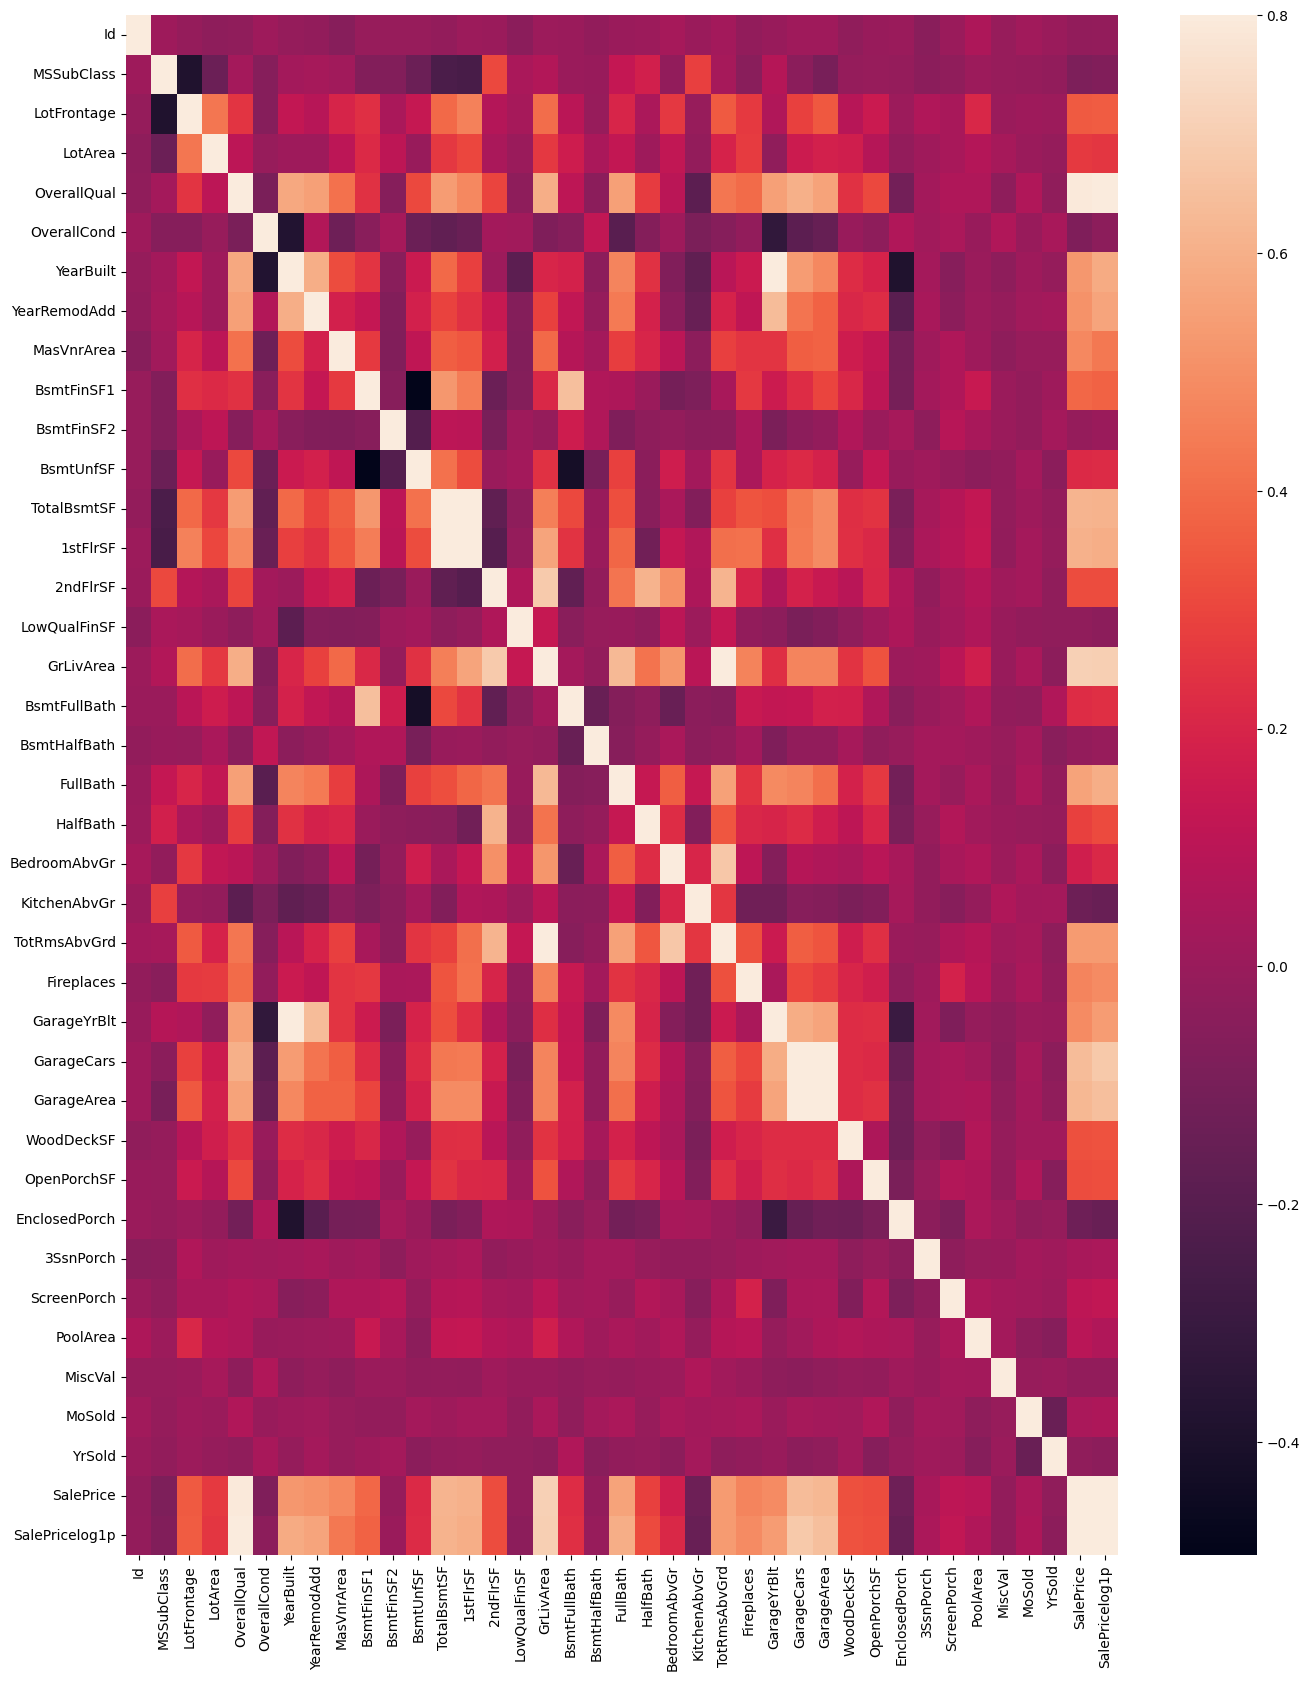

In [26]:
num_corrmat = train_df[train_df.select_dtypes(
    include=['number']).columns].corr()
plt.figure(figsize=(16, 20))
sns.heatmap(num_corrmat, vmax=0.8)


From the heat map it is clear that there are multiple features those have high level of correlation with SalePrice. In order to pick most impacting featurs we will select only those which has correlation above 0.5. Please note it is an arbitrary number.


In [27]:
num_corrmat['SalePrice'].sort_values(ascending=False)


SalePrice         1.000000
SalePricelog1p    0.948374
OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
GarageYrBlt       0.486362
MasVnrArea        0.477493
Fireplaces        0.466929
BsmtFinSF1        0.386420
LotFrontage       0.351799
WoodDeckSF        0.324413
2ndFlrSF          0.319334
OpenPorchSF       0.315856
HalfBath          0.284108
LotArea           0.263843
BsmtFullBath      0.227122
BsmtUnfSF         0.214479
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
MoSold            0.046432
3SsnPorch         0.044584
BsmtFinSF2       -0.011378
BsmtHalfBath     -0.016844
MiscVal          -0.021190
Id               -0.021917
LowQualFinSF     -0.025606
YrSold           -0.028923
OverallCond      -0.077856
MSSubClass       -0.084284
E

<Axes: >

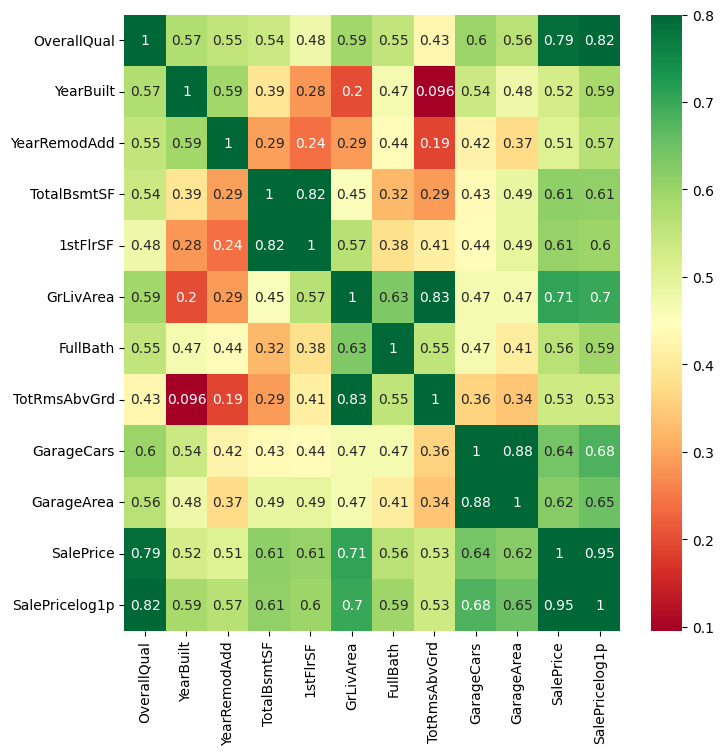

In [28]:
# Select most impacting features
key_features = num_corrmat.index[abs(num_corrmat['SalePrice'] > 0.5)]
key_feature_corr = train_df[key_features].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(key_feature_corr, vmax=0.8, annot=True, cmap="RdYlGn")


In [29]:
key_feature_corr['SalePrice'].sort_values(ascending=False)


SalePrice         1.000000
SalePricelog1p    0.948374
OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
Name: SalePrice, dtype: float64

Plotting key features to visulize their impact


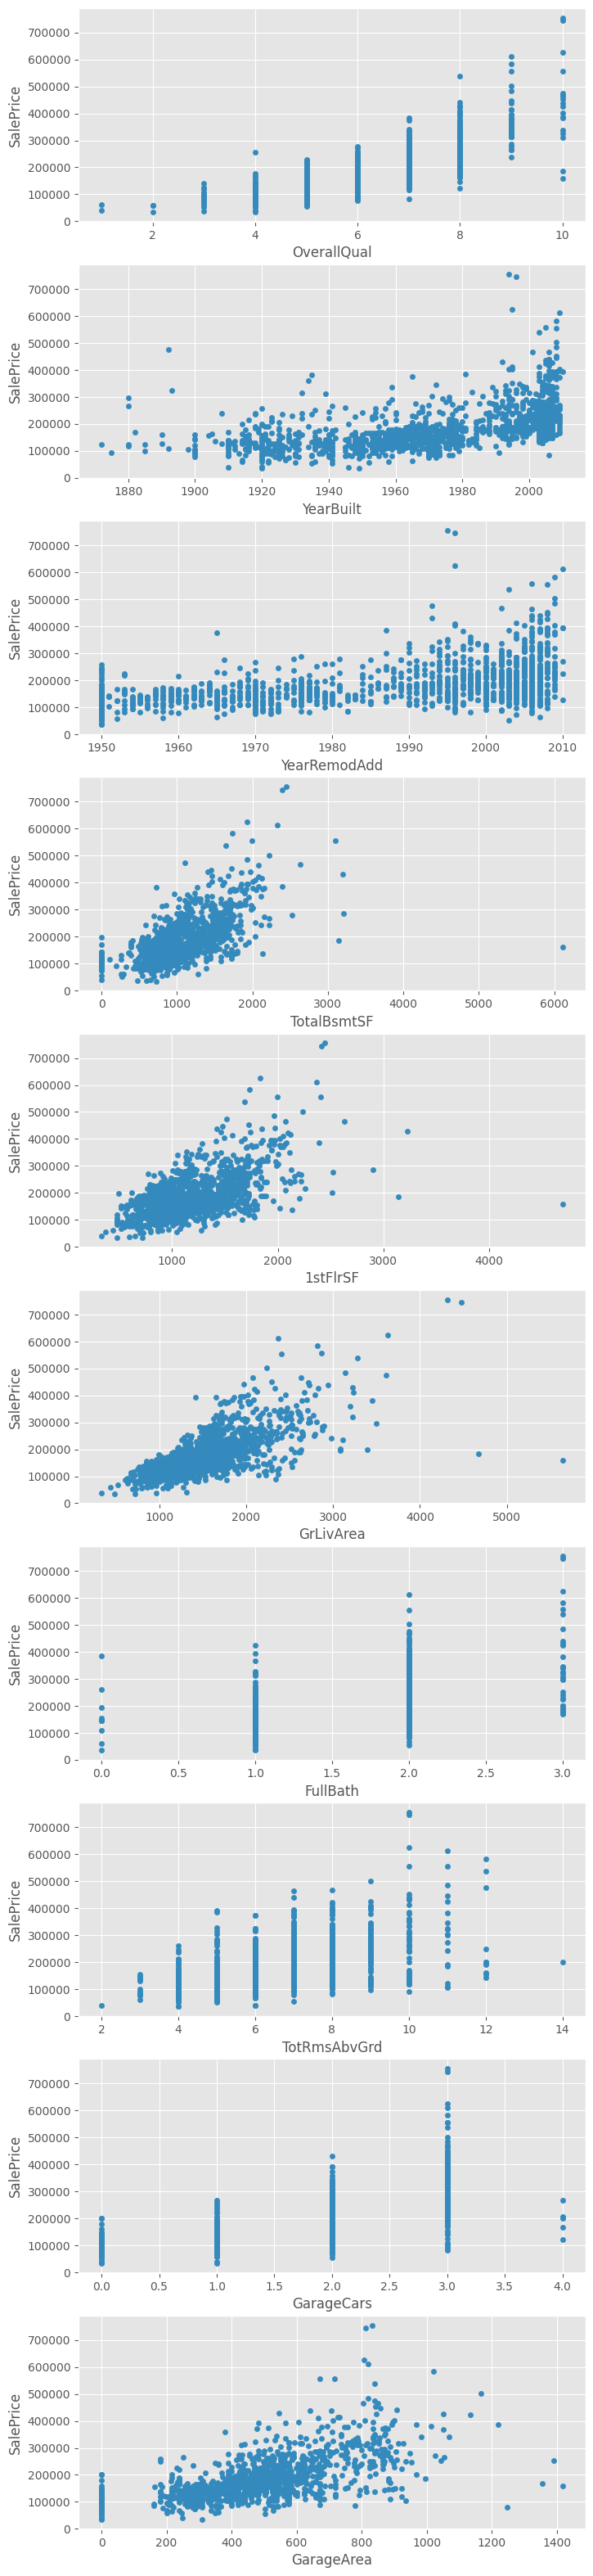

In [31]:
len(key_features)
rows = int(len(key_features)-2)
cols = 1

plt.style.use('ggplot')
fit, axs = plt.subplots(rows, cols, figsize=(8, 40))

for i, feature in enumerate(key_features.tolist()[:-2]):

    # , title=f"{feature} vs SalePrice")
    train_df.plot(kind='scatter', x=feature, y='SalePrice', ax=axs[i])


In [32]:
train_df[key_features].head()


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,SalePricelog1p
0,7,2003,2003,856,856,1710,2,8,2,548,208500,12.247699
1,6,1976,1976,1262,1262,1262,2,6,2,460,181500,12.109016
2,7,2001,2002,920,920,1786,2,6,2,608,223500,12.317171
3,7,1915,1970,756,961,1717,1,7,3,642,140000,11.849405
4,8,2000,2000,1145,1145,2198,2,9,3,836,250000,12.429220


In [33]:
ranking_based = ['OverallQual', 'FullBath', 'TotRmsAbvGrd', 'GarageCars']
year_based = ['YearBuilt', 'YearRemodAdd']
area_based = ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']


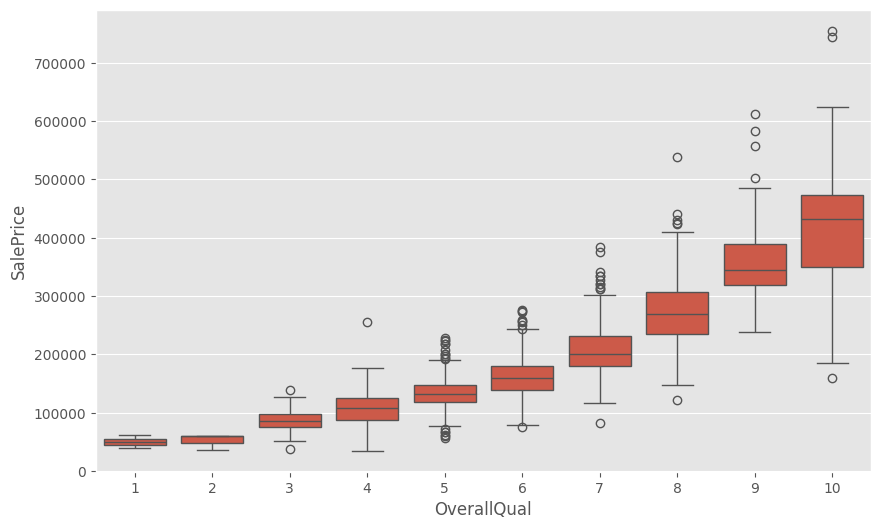

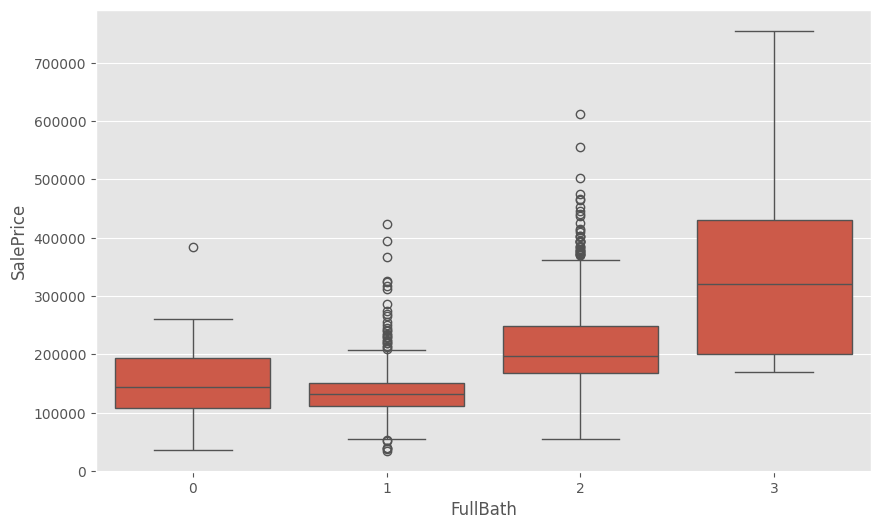

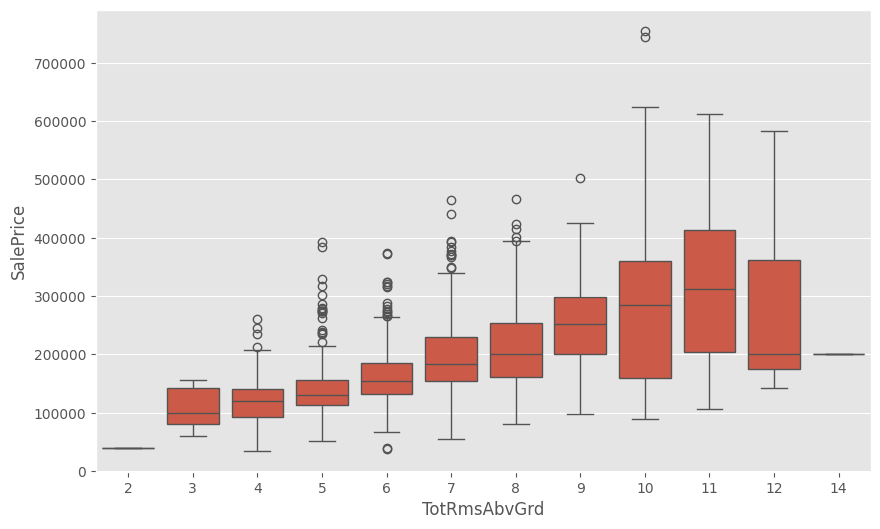

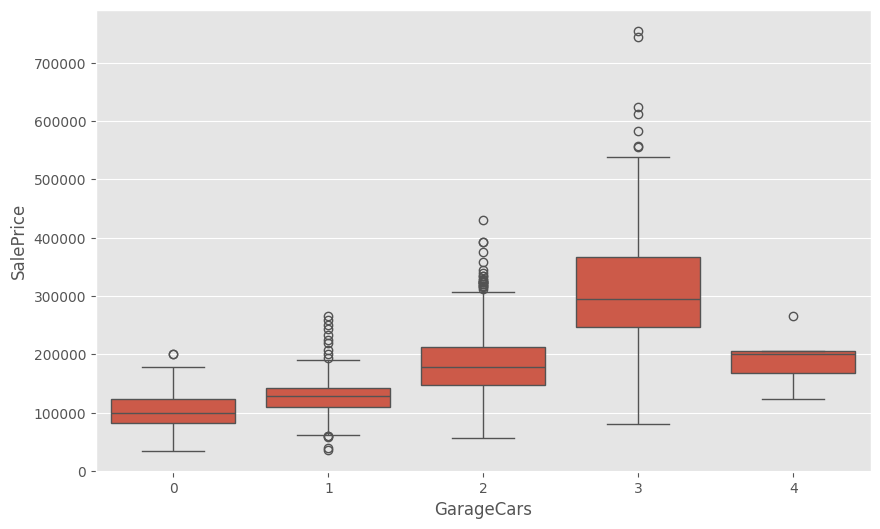

In [35]:
rows = int(len(ranking_based))
cols = 1

plt.style.use('ggplot')
# fit, axs = plt.subplots(rows, cols, figsize = (8, 40))

for i, feature in enumerate(ranking_based):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='SalePrice', data=train_df)


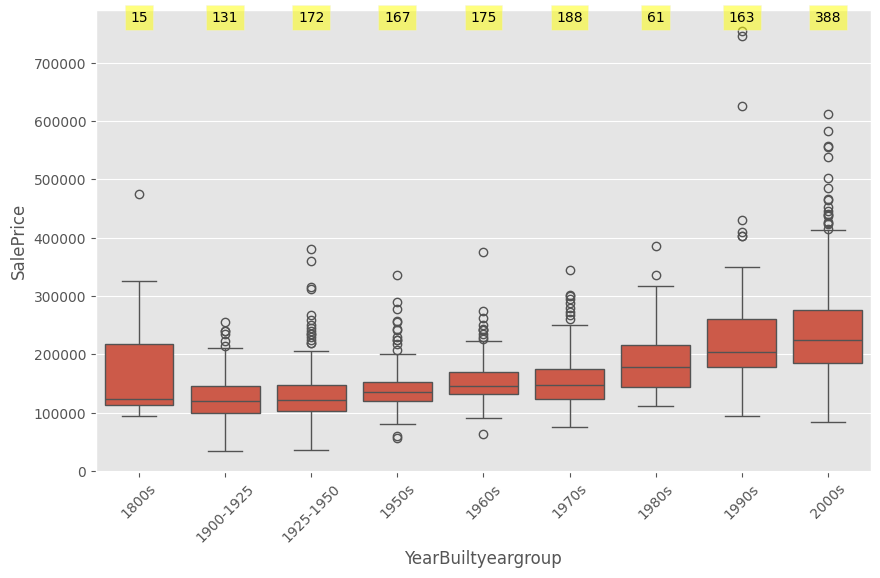

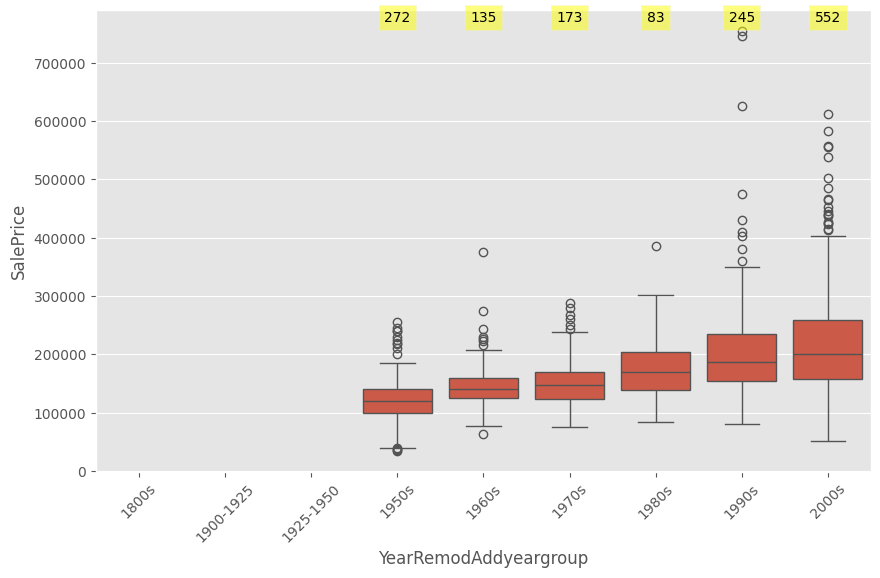

In [36]:
yeargroup = {
    '1800s': range(min(train_df[year_based].min()), 1900),
    '1900-1925': range(1900, 1925),
    '1925-1950': range(1925, 1950),
    '1950s': range(1950, 1960),
    '1960s': range(1960, 1970),
    '1970s': range(1970, 1980),
    '1980s': range(1980, 1990),
    '1990s': range(1990, 2000),
    '2000s': range(2000, max(train_df[year_based].max())+1)
}


def assignyeargroup(year):
    for group, years in yeargroup.items():
        if year in years:
            return group
    return 'other'


train_df[year_based[0]+"yeargroup"] = train_df[year_based[0]
                                               ].apply(assignyeargroup)
train_df[year_based[1]+"yeargroup"] = train_df[year_based[1]
                                               ].apply(assignyeargroup)
counts = train_df[year_based[0] +
                  "yeargroup"].groupby(train_df[year_based[0]+"yeargroup"]).count()


# # Create the boxplot using seaborn
for item in year_based:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x=item+"yeargroup", y='SalePrice',
                     data=train_df, order=yeargroup.keys())
    plt.xticks(rotation=45)
    for i, label in enumerate(ax.get_xticklabels()):
        try:
            count = train_df[item+"yeargroup"].value_counts()[label.get_text()]
            ax.text(i, ax.get_ylim()[1]-20000,  str(count), ha='center',
                    fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
        except:
            pass


Machine learning models application


In [38]:
# Selecting multiple models to run and test the outputs
models = {"linearregresson": LinearRegression(),
          "lasso": Lasso(alpha=0.5),
          "lassocv": LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                     0.3, 0.6, 1], max_iter=10000, cv=5),
          "lassolars": LassoLars(),
          "gradientboostreg": GradientBoostingRegressor(),
          "randomforest": RandomForestRegressor(),
          }


# Define RMSE function as it is not available in sklearn.metrics
def rmse_calc(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def training_loop(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_train = rmse_calc(y_train, y_train_pred)
        rmse_test = rmse_calc(y_test, y_test_pred)

        results[name] = {
            "mse_train": mse_train,
            "mse_test": mse_test,
            "rmse_train": rmse_train,
            "rmse_test": rmse_test
        }

    return results

# Select features based upon correlation value, split data into train/test and run models


def feature_select(corr=[0.5]):
    final_results = {}
    if not isinstance(corr, list):
        print(
            f"This function will accept only a list, value you passed {type(corr)} is incorrect")
    else:
        for item in corr:
            select_feature = num_corrmat.index[abs(
                num_corrmat['SalePrice'] > item)]
            X_train, X_test, y_train, y_test = train_test_split(
                train_df[select_feature[:-2]],
                train_df[select_feature[-1]],
                test_size=0.2,
                shuffle=False,
                random_state=42
            )
            final_results["corr_"+str(item)] = training_loop(models,
                                                             X_train, X_test, y_train, y_test)
    return final_results


output = feature_select([0.5, 0.6, 0.7])


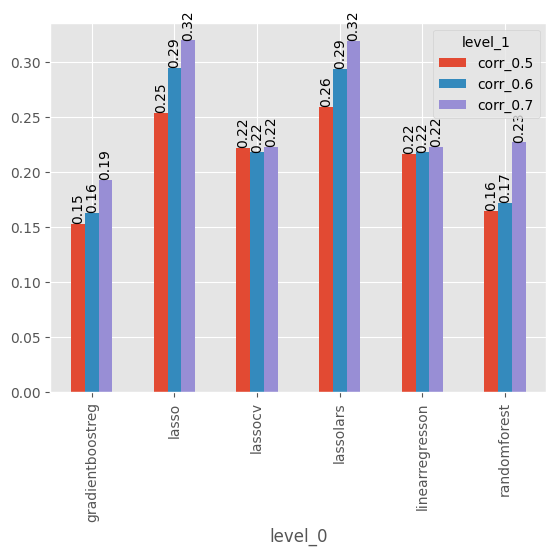

In [39]:
# Storing output into panda Datafram that will help us to plot and compare results
output_df = pd.DataFrame(output)
output_df = output_df.stack().apply(pd.Series)
output_df = output_df.reset_index()
output_df = output_df.pivot(
    index=output_df.columns[0], columns=output_df.columns[1])

output_df["rmse_test"].plot(kind='bar')

for rect in plt.gcf().get_axes()[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    plt.text(x_value, y_value, f"{float(y_value):.2f}",
             ha='center', va='bottom', rotation=90)


Best Performaning model :

We used 7 different machine learning models and from the above we can see best result is acheived by GradientboostingRegressor which we will use to predict the price of the houses. And it worked best when we selected features with correlation value above 0.5 with SalePrice


In [40]:
selected_model = GradientBoostingRegressor()
selected_features = num_corrmat.index[abs(num_corrmat['SalePrice'] > 0.5)]
selected_model.fit(train_df[selected_features[:-2]],
                   train_df['SalePricelog1p'])
y_train_pred = selected_model.predict(train_df[selected_features[:-2]])


In [42]:
# Taking inverse log to get actual value of training data
y_train_pred_values = np.expm1(y_train_pred)
rmse_calc(train_df['SalePrice'], y_train_pred_values)

# The RMSE value is only 21475 as shown above which is reasonable and showing our regression model is performaing ok with the given constraints


21475.485286557956

PREDICTING HOUSE PRICES


In [43]:
test_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [44]:
test_df[selected_features[:-2]].isnull().sum()


OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     1
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      1
GarageArea      1
dtype: int64

In [46]:
test_df[selected_features[:-2]] = test_df[selected_features[:-2]
                                          ].fillna(test_df[selected_features[:-2]].mean())

test_pred = selected_model.predict(test_df[selected_features[:-2]])
# Applying inverse log
test_pred_prices = np.expm1(test_pred)
test_pred_prices[:10]


array([120453.72879774, 141368.12809063, 169500.72034087, 177927.17320585,
       202922.61165662, 182243.30428488, 166158.20407217, 169867.88914728,
       188583.69338951, 115790.15811063])

In [47]:
test_results = pd.DataFrame(
    {'SalePrice': test_pred_prices.astype(int)}, index=test_df['Id'])


In [50]:
test_results.head(15)


,SalePrice
Id,
1461,120453
1462,141368
1463,169500
1464,177927
1465,202922
1466,182243
1467,166158
1468,169867
1469,188583


In [49]:
test_results.to_csv('test_prediction.csv')
